In [ ]:
# Copyright InfinityQ Tech 2024

# Prompt the user and wait for an answer before installing dependencies.
# Note: Usage of a virtual Python environment is recommended.
if input("Install Python dependencies? [y/n]").lower() == "y":
    !pip install -r "requirements.txt" --upgrade
else:
    print("Skipping dependency installation.")

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from clustering_utils import *
from titanq import Model, Vtype, Target, S3Storage

import gurobipy as gp
from gurobipy import GRB

from sklearn.cluster import KMeans
from statistics import median, variance, stdev

In [ ]:
# Enter your API Key Here
# Obtain your API key by contacting --> support@infinityq.tech
# Example: TITANQ_DEV_API_KEY = "00000000-0000-0000-0000-000000000000"
TITANQ_DEV_API_KEY = None

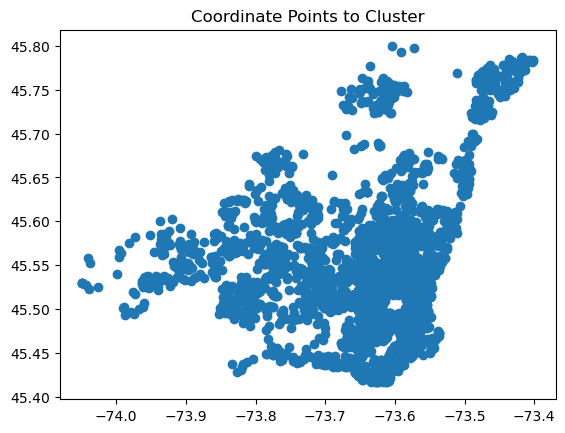

In [3]:
#------------------------------------------------------------------------------
#Specify Total Number of Coordinates + Desired Number of Clusters to Generate
#------------------------------------------------------------------------------
n_coords = 3000              #Total number of points to cluster (Options: 8, 500, 2000, 3000)
n_clusters = 3               #Number of clusters to extract from the data set

try:
    f = open('instances/input_' + str(n_coords) + '.json')
    data = json.load(f)["found"]
    coords = []
    for coord in data:
        coords.append([coord['Longitude'],coord['Latitude']])

    plt.title("Coordinate Points to Cluster")
    plt.scatter([item[0] for item in coords],[item[1] for item in coords])

except:
    print("ERROR. Input file size does not exist. Must specify n_coords = 8, 500, 2000, or 3000.")

#For plotting generated clusters
color_map = {0:"blue", 1:"red", 2:"orange", 3:"green", 4:"black", 5:"pink", 6:"brown", 7:"teal", 8:"grey", 9:"purple"}

In [4]:
#Specify scaling factor for cluster re-balancing (Setting this value to 0.0 deactivates the feature)
lambda_scaling_factor = 0.0

dist_matrix = gen_dist_matrix(coords)
weight_matrix, bias_vector = gen_Jh_cluster(dist_mat=dist_matrix, coords=coords, n_clusters=n_clusters, lambda_scaling_factor=lambda_scaling_factor, k_avg=n_coords/n_clusters, B=1)

### TitanQ

In [5]:
model = Model(api_key=TITANQ_DEV_API_KEY)
model.add_variable_vector('x', n_clusters*n_coords, Vtype.BINARY)
model.set_objective_matrices(weight_matrix, bias_vector, Target.MINIMIZE)

#Constraint mask for set partioning constraint
constraint_mask = np.zeros((n_coords, n_clusters*n_coords))
offset = 0
for row in range(n_coords):
    for col in range(n_clusters):
        constraint_mask[row, offset + col] = 1
    offset += n_clusters
model.add_set_partitioning_constraints_matrix(constraint_mask)

In [6]:
#----------------
#Hyperparameters
#----------------
try:
    #Retrieve pre-tuned hyperparameters on existing combinations for the number of clusters and number of coordinates
    T_min, T_max, coupling_mult, num_chains, num_engines, timeout = load_hyperparameters(n_coords, n_clusters, lambda_scaling_factor)
except:
    #Otherwise, use a manually specified set of hyperparameters 
    T_min = 0.01
    T_max = 100 
    coupling_mult = 0.1
    num_chains = 128
    num_engines = 1
    timeout = 10

betas = 1/(np.linspace(T_min, T_max, num_chains, dtype=np.float32))

response = model.optimize(beta=betas, coupling_mult=coupling_mult, timeout_in_secs=timeout, num_chains=num_chains, num_engines=num_engines)
activations = np.nonzero(np.reshape(response.x, (-1, n_clusters)))[1]

#Store for performance metric calculations
titanQ_clusters_dict = {}
for i in range(len(activations)):
    if activations[i] in titanQ_clusters_dict:
        titanQ_clusters_dict[activations[i]].append((coords[i][0], coords[i][1]))
    else:
        titanQ_clusters_dict[activations[i]] = [(coords[i][0], coords[i][1])]

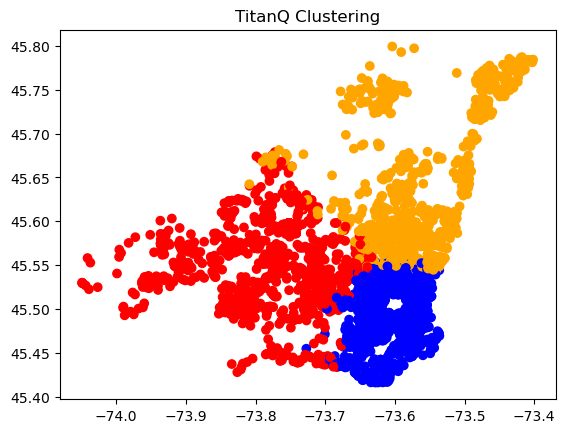

In [7]:
#Plotting
titanQ_colors = []
for val in activations:
    titanQ_colors.append(color_map[val])

plt.figure()
plt.title("TitanQ Clustering")
plt.scatter([item[0] for item in coords],[item[1] for item in coords], c=titanQ_colors)

### Gurobi

In [8]:
#Model
model = gp.Model("Clustering")

#Decision variables
x = {}  # x[i, k] = 1 if data point i belongs to cluster k

for i in range(n_coords):
    for k in range(n_clusters):
        x[(i, k)] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{k}")

obj_func = gp.quicksum(dist_matrix[(i,j)] * x[(i,k)] * x[(j,k)]
                        for i in range(n_coords) 
                        for j in range(i+1,n_coords)
                        for k in range(n_clusters)
                        if (i, k) in x
                        if (j, k) in x)   

model.setObjective(obj_func, GRB.MINIMIZE)

#Constraints
for i in range(n_coords):
    model.addConstr(
            gp.quicksum(x[(i, k)] for k in range(n_clusters)
                        if (i, k) in x) == 1,
            name=f"set_partitioning_{i}"
        )

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-30


In [9]:
#Solve the model
try:
    model.optimize()

except:
    print("Gurobi error")

#Print results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found.")      
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Xeon(R) Silver 4214R CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 3000 rows, 9000 columns and 9000 nonzeros
Model fingerprint: 0xf24819b0
Model has 13492869 quadratic objective terms
Variable types: 0 continuous, 9000 integer (9000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1419448.3066
Presolve removed 0 rows and 0 columns (presolve time = 56s) ...
Presolve time: 56.27s
Presolved: 3000 rows, 9000 columns, 9000 nonzeros
Presolved model has 13501869 quadratic objective terms
Variable types: 0 continuous, 9000 integer (9000 binary)
Found heuristic solution: objective 1342394.6470

Root 

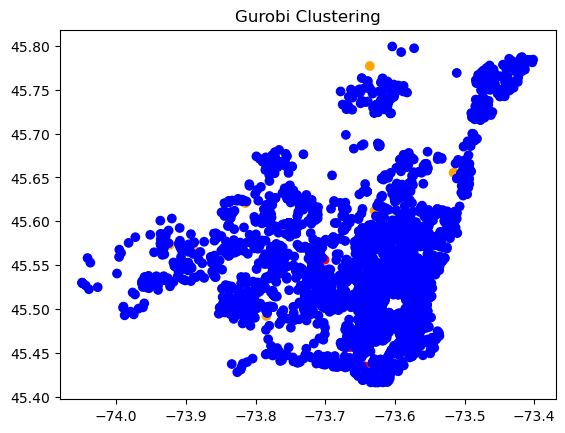

In [10]:
#Plotting
gurobi_colors = []
gurobi_clusters_dict = {}

for (i,k) in x:
    if x[(i, k)].x > 0.5: #The value of 0.5 is the LP tolerance
        gurobi_colors.append(color_map[k])

        #Store for performance metric calculations
        if k in gurobi_clusters_dict:
            gurobi_clusters_dict[k].append((coords[i][0], coords[i][1]))
        else:
            gurobi_clusters_dict[k] = [(coords[i][0], coords[i][1])]

plt.figure()
plt.title("Gurobi Clustering")
plt.scatter([item[0] for item in coords],[item[1] for item in coords], c=gurobi_colors)

### K-Means

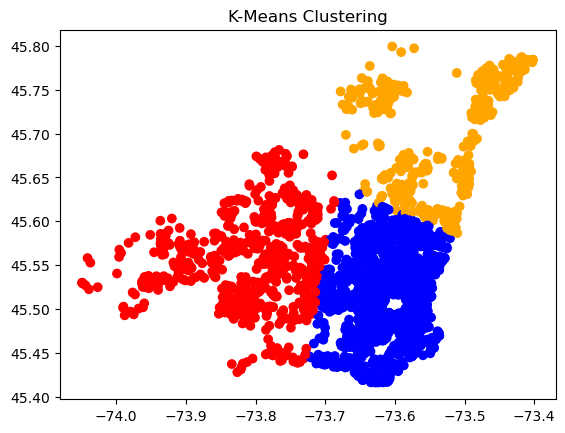

In [11]:
kmeans_test = KMeans(n_clusters=n_clusters).fit(coords)

#Store for performance metric calculations
kmeans_clusters = {}
for i in range(len(kmeans_test.labels_)):
    if kmeans_test.labels_[i] in kmeans_clusters:
        kmeans_clusters[kmeans_test.labels_[i]].append((coords[i][0], coords[i][1]))
    else:
        kmeans_clusters[kmeans_test.labels_[i]] = [(coords[i][0], coords[i][1])]

#Plotting
kmeans_colors = []
for val in kmeans_test.labels_:
    kmeans_colors.append(color_map[val])

plt.figure()
plt.title("K-Means Clustering")
plt.scatter([item[0] for item in coords],[item[1] for item in coords], c=kmeans_colors)

### Performance Metrics

In [12]:
#----------------------------------------------
#Intracluster Performance Metric Calculations
#----------------------------------------------
titanQ_intracluster_distances = intracluster_distance_calculation(titanQ_clusters_dict)
gurobi_intracluster_distances = intracluster_distance_calculation(gurobi_clusters_dict)
kmeans_intracluster_distances = intracluster_distance_calculation(kmeans_clusters)

#----------------------------------------------
#Intercluster Performance Metric Calculations
#----------------------------------------------
titanQ_intercluster_distances = intercluster_distance_calculation(titanQ_clusters_dict)
gurobi_intercluster_distances = intercluster_distance_calculation(gurobi_clusters_dict)
kmeans_intercluster_distances = intercluster_distance_calculation(kmeans_clusters)

In [13]:
#--------------------
#Median Calculations
#--------------------
titanQ_intracluster_median = median(titanQ_intracluster_distances)
titanQ_intercluster_median = median(titanQ_intercluster_distances)

gurobi_intracluster_median = median(gurobi_intracluster_distances)
gurobi_intercluster_median = median(gurobi_intercluster_distances)

kmeans_intracluster_median = median(kmeans_intracluster_distances)
kmeans_intercluster_median = median(kmeans_intercluster_distances)

print("TitanQ Intracluster Median:", titanQ_intracluster_median)
print("TitanQ Intercluster Median:", titanQ_intercluster_median)
print()

print("Gurobi Intracluster Median:", gurobi_intracluster_median)
print("Gurobi Intercluster Median:", gurobi_intercluster_median)
print()

print("K-Means Intracluster Median:", kmeans_intracluster_median)
print("K-Means Intercluster Median:", kmeans_intercluster_median)

TitanQ Intracluster Median: 0.17765993866525887
TitanQ Intercluster Median: 0.1877409495796208

Gurobi Intracluster Median: 0.22588869428571756
Gurobi Intercluster Median: 0.0628981366637262

K-Means Intracluster Median: 0.1669568392389101
K-Means Intercluster Median: 0.2044097267422052
